## Проект компьюьтерного зрения

Супермаркет внедряет систему компьютерного зрения для определния возраста покупателей.

Это поможет лучше понимать нужды возрастных категорий и контролировать работу продавцов по продаже алкоголя.

**Цель**

Построить модель по определнию возраста человека по фотографии. В распоряжении имется набор фотографий с указанием возраста человека, изображенного на них. (Данные взяты с сайта ChaLearn Looking at People.)

# 1. Исследовательский анализ данных

Прежде построения модели, исследуем предоставленные данные

In [10]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense, Conv2D, AvgPool2D, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

from PIL import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
labels = pd.read_csv('/datasets/faces/labels.csv').reset_index()
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Импортируем данные. И проверим их количество

In [12]:
print(labels.shape)

(7591, 3)


In [13]:
age_group = labels.groupby(labels['real_age']).count().reset_index()
display(age_group)

,real_age,index,file_name
0,1,149,149
1,2,88,88
2,3,25,25
3,4,101,101
4,5,87,87
...,...,...,...
92,94,5,5
93,95,2,2
94,96,2,2
95,97,1,1


Больше всего фотографий людей 30 летнего возраста

Исследуем распределение возрастов на графике, а также посомтрим как выглядят сами фотографии и хорошо ли согласуется указанный возраст с изображением.

Text(0.5, 1.0, 'Распределение по возрасту')

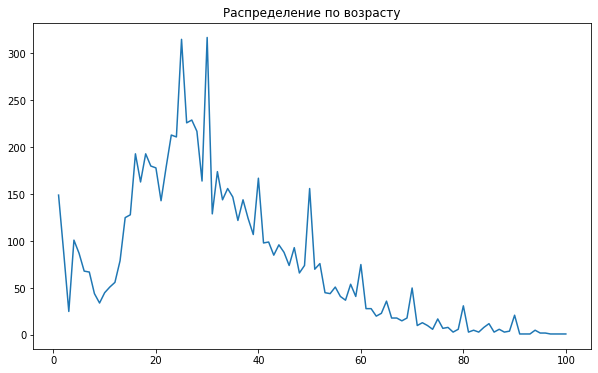

In [14]:
color_rectangle = np.random.rand(25, 3)
plt.figure(figsize=(10,6))
plt.plot(age_group['real_age'],age_group['file_name'])
plt.title('Распределение по возрасту')

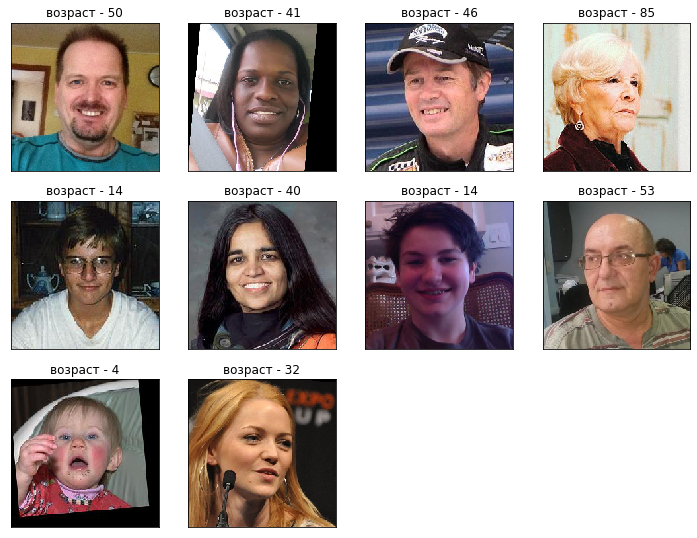

In [6]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title('возраст - ' + str(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## Итог исследовательского анализа

- В датасете представлено 7591 данных, для увеличения данных для обучения можно использовать аугментацию. Можно использовать horizontal_flip, чтобы несильно перегружать модель.

- По графику можно увидеть, что распределение нормальное с положительной скошенностью, виден отчетливый выброс на 0 лет. Не будем удалять данные людей с возрастом 0, чтобы не уменьшать выборку, допустим что в базе много младенцев из-за того, что они няшные. Диапазон между 20 - 40 лет встречается чаще всего.

- На фотографиях изображены люди. В основном на фотографиях только лица, но есть и те, где человек изображен во весь рост. У изображений наблюдается различное качество, но на модель это не должно повлиять, так как сами лица и их основные черты видны.

- Указанный возраст согласуется с изображениями

# 2. Обучение модели

Для определения возраста по фотографии, построим и обучим нейронную сеть на датасете с фотографиями людей.

**Задача**: добиться значения метрики MAE на тестовой выборке не больше 8

Для этого написаны две функции для загрузки обучающей и тестовой выборок.

Функция для модели: использование ResNet50, в конце добавим слой с усреднением и полносвязный слой для классификации

Последняя функция - обучение модели на выборки, с количеством эпох = 20

```python
def load_train(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow
    
def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return test_gen_flow
  
def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    opt = Adam(lr=0.0001)
    model.compile(loss='mse', optimizer=opt, metrics=['mae'])

    return model
    
def train_model(model, train_data, test_data, batch_size=None,
                epochs=20, steps_per_epoch=None, validation_steps=None):
                
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model
```

Train for 356 steps, validate for 119 steps
Epoch 1/20
356/356 - 119s - loss: 207.8842 - mae: 10.5229 - val_loss: 465.6733 - val_mae: 16.4503

Epoch 10/20
356/356 - 42s - loss: 13.9447 - mae: 2.8238 - val_loss: 63.4091 - val_mae: 5.9295

Epoch 20/20
356/356 - 42s - loss: 9.6036 - mae: 2.3691 - val_loss: 65.3722 - val_mae: 6.1072

119/119 - 10s - loss: 65.3722 - mae: 6.1072
Test MAE: 6.1072

Удалось добиться поставленной задачи, MAE меньше 8.

# 3. Общий итог

- Проведен исследовательский анализ данных. Выяснено, что наибольшее количество фотографий людей возраста от 20 до 40 лет. Указанный возраст соответствовал фотографиям.


- Построена модель на основе ResNet50, в качестве метрики использовалась - MAE, которая показала на тестовой выборке неплохой результат - 6.1. Следовательно наша модель сможет определять возраст фотографии с ошибкой примерно в 6 лет. В целом подростка от старика определить сможет.


- Модель можно использовать для определния возраста в магазине.